In [1]:
# !pip install svgwrite svgpathtools
# !pip install cairosvg bitsandbytes
# !pip install git+https://github.com/openai/CLIP.git
# !pip install -q opencv-python scikit-image pillow
# !pip install scour cssutils

In [2]:
#| default_exp core

In [3]:
#| export

import kagglehub
import shutil
import os
import sys
from pathlib import Path
import subprocess

# diffvg_path = kagglehub.dataset_download('tomirol/diffvg')
# out_path = Path("/tmp/diffvg").resolve()

# if not out_path.exists():
#     shutil.copytree(Path(diffvg_path) / "diffvg", str(out_path))
#     output = subprocess.check_output(f"pip uninstall tensorflow -y && cd {str(out_path)} && python setup.py install", shell=True, text=True)

# sys.path.append(str(out_path / "dist/diffvg-0.0.1-py3.10-linux-x86_64.egg"))


In [4]:
#| export

draw_src_path = kagglehub.dataset_download('tomirol/drawsrc')

out_path = Path("/tmp/drawsrc")

if not out_path.exists():
    shutil.copytree(str(draw_src_path), out_path)

sys.path.append(str(out_path))

In [5]:
#| export

primitive_path = kagglehub.dataset_download('tomirol/primitive')

out_path = Path("/tmp/primitive")

if not out_path.exists():
    shutil.copy(Path(primitive_path) / "primitive", out_path)
    subprocess.check_output(f"chmod +x {out_path}", shell=True, text=True)

In [6]:
#| export

import sys
import site
from importlib import invalidate_caches

# Refresh sys.path
site.main()
invalidate_caches()

In [7]:
#| export

# import os
# os.environ["TORCH_COMPILE_DISABLE"] = "1"

from pydantic import BaseModel
from PIL import Image
import re
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import kagglehub
import subprocess
import scour.scour


import os
import kornia
import torch.nn as nn
import copy
import random
import pandas as pd
import cv2
import json
import cairosvg
from pathlib import Path
import io
from torch.nn import functional as F
import numpy as np
import torch
from tqdm.auto import tqdm
import pydiffvg


from src.score_original import VQAEvaluator, ImageProcessor, AestheticEvaluator
from src.score_gradient import (
    score_original,
    score_gradient,
    aesthetic_score_original,
    vqa_score_original,
    aesthetic_score_gradient,
    vqa_score_gradient,
)
from src.preprocessing import apply_preprocessing_torch

from src.text_to_svg import text_to_svg


device_0 = f"cuda:{max(0, torch.cuda.device_count() - 2)}"
device_1 = f"cuda:{max(0, torch.cuda.device_count() - 1)}"

In [8]:
#| export


class BaseConfig(BaseModel):
    width: int = 384
    height: int = 384


class SDConfig(BaseConfig):
    stable_diffusion_path: str = kagglehub.model_download("stabilityai/stable-diffusion-v2/pytorch/1/1")
    prompt_prefixes: list[str] = ["Simple, classic image of"]
    prompt_suffixes: list[str] = ["with flat color blocks, beautiful, minimal details, solid colors only"]
    negative_prompts: list[str] = ["lines, framing, hatching, background, textures, patterns, details, outlines"]
    num_inference_steps: int = 25
    guidance_scale: int = 20


class TextConfig(BaseConfig):
    x_position_frac: float = 0.9
    y_position_frac: float = 0.9
    font_size: int = 45
    color: tuple[int, int, int] = (255, 255, 255)
    font_path: str = ""


class PrimitiveConfig(BaseConfig):
    mode: int = 8
    num_shapes: int = 100


class DiffvgConfig(BaseConfig):
    num_iterations: int = 80
    validation_steps: int = 20
    base_svg_path: str = str(Path(kagglehub.dataset_download('tomirol/aestsvg')) / "default_aest_0500.svg")
    # base_svg_path: str = str(Path(kagglehub.dataset_download('tomirol/aestsvg')) / "default_aest_0500_org_ocr.svg")


In [9]:
#| export

def generate_sd_image(pipe: StableDiffusionPipeline, prompt: str, config: SDConfig) -> list[Image.Image]:
    images = []
    for prompt_prefix, prompt_suffix, negative_prompt in zip(config.prompt_prefixes, config.prompt_suffixes, config.negative_prompts):
        image = pipe(
            prompt=f'{prompt_prefix} {prompt} {prompt_suffix}',
            negative_prompt=negative_prompt,
            num_inference_steps=config.num_inference_steps,
            guidance_scale=config.guidance_scale,
        ).images[0]
        images.append(image)

    return images[0]

In [10]:
#| export

def generate_primitive_svg(
    image: Image.Image,
    size: int = 384,
    mode: int = 8,
    num_shapes: int = 100,
    temp_path: str = "/tmp/image.png",
    max_size: int = 5700
) -> str:
    temp_path_svg = temp_path.replace(".png", ".svg")
    image = image.resize((size, size))

    image.save(temp_path)

    args = [
        "/tmp/primitive",
        "-i",
        temp_path,
        "-o",
        temp_path_svg,
        "-n",
        str(num_shapes),
        "-m",
        str(mode),
        "-r",
        f"{size}",
        "-s",
        f"{size}",
    ]
    subprocess.run(args)

    with open(temp_path_svg, "r") as f:
        svg = f.read()
    
    svg = polygon_to_path(svg)
    
    cur_svg = svg
    svg_lines = svg.strip().split("\n")
    keep_idx = [1] * len(svg_lines)
    cur_idx = len(svg_lines) - 1

    while len(optimize_svg(cur_svg).encode('utf-8')) > max_size:
        if "<path" in svg_lines[cur_idx]:
            keep_idx[cur_idx] = 0

        cur_idx -= 1
        cur_svg = "\n".join([line for i, line in enumerate(svg_lines) if keep_idx[i]])
        
    print(f"Avg keep: {np.mean(keep_idx)}")
    print(len(optimize_svg(cur_svg).encode('utf-8')))
    
    svg = cur_svg

    # svg += text_to_svg("A", x_position_frac=0.9, y_position_frac=0.9, font_size=45, color=(255, 255, 255), font_path="/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf").split("\n")[1]
    svg += text_to_svg("O", x_position_frac=0.6, y_position_frac=0.85, font_size=60, color=(255, 255, 255), font_path="/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf").split("\n")[1]
    svg += text_to_svg("C", x_position_frac=0.75, y_position_frac=0.85, font_size=60, color=(0, 0, 0), font_path="/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf").split("\n")[1]

    svg = svg.replace("</svg>", "") + "</svg>"

    return svg

In [11]:
#| export

def polygon_to_path(svg: str) -> str:
    svg = re.sub(
        r'<polygon([\w\W]+?)points=(["\'])([\.\d, -]+?)(["\'])', 
        r'<path\1d=\2M\3z\4', 
        svg
    )
    svg = re.sub(
        r'<polyline([\w\W]+?)points=(["\'])([\.\d, -]+?)(["\'])', 
        r'<path\1d=\2M\3\4', 
        svg
    )
    return svg

def merge_svgs(bg_svg: str, aest_svg: str):
    aest_svg = aest_svg.strip().split("\n")[2:-1]
    # aest_svg = [
    #     '<g clip-path="polygon(32px 32px, 80px 32px, 80px 80px, 32px 80px)">',
    #     # '<svg x="32" y="32" width="48" height="48" viewBox="32 32 48 48" overflow="hidden">',
    #     *aest_svg,
    #     '</g>'
    # ]
    aest_svg = "\n".join(aest_svg)
    
    bg_svg = polygon_to_path(bg_svg)
    svg = bg_svg + '\n' + aest_svg
    svg = svg.replace("</svg>", "") + "</svg>"

    return svg


def svg_to_png_no_resize(svg_code: str) -> Image.Image:
    png_data = cairosvg.svg2png(bytestring=svg_code.encode('utf-8'))
    img_pil = Image.open(io.BytesIO(png_data)).convert('RGB')
    return img_pil


def apply_random_crop_resize_seed(image: Image.Image, crop_percent=0.05, seed=42):
    rs = np.random.RandomState(seed)
    
    width, height = image.size
    crop_pixels_w = int(width * crop_percent)
    crop_pixels_h = int(height * crop_percent)

    left = rs.randint(0, crop_pixels_w + 1)
    top = rs.randint(0, crop_pixels_h + 1)
    right = width - rs.randint(0, crop_pixels_w + 1)
    bottom = height - rs.randint(0, crop_pixels_h + 1)

    image = image.crop((left, top, right, bottom))
    image = image.resize((width, height), Image.BILINEAR)

    return image


def get_optimization_settings():
    settings = pydiffvg.SvgOptimizationSettings()

    lr = 5e-3

    settings.global_override(["optimizer"], "Adam")
    settings.global_override(["color_lr"], lr)
    settings.global_override(["alpha_lr"], lr)
    settings.global_override(["paths", "shape_lr"], 10*lr)
    settings.global_override(["circles", "shape_lr"], 10*lr)
    settings.global_override(["transforms", "transform_lr"], 10*lr)
    
    settings.global_override(["gradients", "optimize_stops"], True)
    settings.global_override(["gradients", "stop_lr"], lr)
    settings.global_override(["gradients", "optimize_color"], True)
    settings.global_override(["gradients", "color_lr"], lr)
    settings.global_override(["gradients", "optimize_alpha"], True)
    settings.global_override(["gradients", "alpha_lr"], lr)
    settings.global_override(["gradients", "optimize_location"], True)
    settings.global_override(["gradients", "location_lr"], 10*lr)

    settings.global_override(["optimize_color"], True)
    settings.global_override(["optimize_alpha"], True)
    settings.global_override(["paths", "optimize_points"], True)
    settings.global_override(["circles", "optimize_center"], True)
    settings.global_override(["circles", "optimize_radius"], True)
    settings.global_override(["transforms", "optimize_transforms"], True)

    return settings


def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False


def generate_diffvg_svg(
    bg_svg: str,
    base_svg_path: str,
    evaluator: AestheticEvaluator,
    width: int = 384,
    height: int = 384,
    num_iterations: int = 100,
    validation_steps: int = 10,
    device: str = device_0,
    num_eval: int = 4
) -> Image.Image:
    pydiffvg.set_use_gpu(True)

    bg_image = svg_to_png_no_resize(bg_svg)
    bg_image = bg_image.resize((width, height))
    bg_image = np.array(bg_image)
    bg_image = torch.from_numpy(bg_image).to(device).permute(2, 0, 1).float() / 255.0

    mask = torch.zeros((3, height, width), dtype=torch.float32, device=device)
    mask[:, 32:80, 32:80] = 1

    settings = get_optimization_settings()

    text_path_ids = [f"text-path-{i}" for i in range(100)] + [f"background-{i}" for i in range(10)]
    for text_id in text_path_ids:
        text_settings = settings.undefault(text_id)
        text_settings["paths"]["optimize_points"] = False
        text_settings["optimize_color"] = False
        text_settings["optimize_alpha"] = False
        text_settings["optimize_transforms"] = False

    optim_svg = pydiffvg.OptimizableSvg(
        base_svg_path, settings, optimize_background=False, verbose=False, device=device
    )

    best_svg = optimize_svg(merge_svgs(bg_svg, optim_svg.write_xml()))
    best_val_loss = -1e8
    
    grad_accumulation_steps = 1

    pbar = tqdm(total=num_iterations)

    for iter_idx in range(num_iterations):
        optim_svg.zero_grad()
        image = optim_svg.render(seed=iter_idx)
        img = image[:, :, :3].permute(2, 0, 1).clamp(0, 1)

        # img = img * mask + bg_image * (1 - mask)

        mask = (img == 0).all(dim=0).unsqueeze(0).float()
        img = (1.0 - mask) * img + mask * bg_image
        
        crop_frac = 0.05
        random_size = int(random.uniform(1.0 - crop_frac, 1.0) * image.shape[1])
        img = kornia.augmentation.RandomCrop((random_size, random_size))(img.unsqueeze(0)).squeeze(0)

        img = apply_preprocessing_torch(img)

        loss = aesthetic_score_gradient(evaluator, img).mean()

        if iter_idx == 0 or (iter_idx + 1) % validation_steps == 0:
            torch.cuda.empty_cache()
            
            aest_svg = optim_svg.write_xml()
            cur_svg = merge_svgs(bg_svg, aest_svg)
            cur_svg_opt = optimize_svg(cur_svg)
            pil_image = svg_to_png_no_resize(cur_svg_opt)
            val_loss = 0.0
            
            for eval_idx in range(num_eval):
                pil_image_eval = pil_image.copy()
                pil_image_eval = apply_random_crop_resize_seed(pil_image_eval, crop_percent=0.03, seed=eval_idx)
                pil_image_eval = ImageProcessor(pil_image_eval).apply().image
                val_loss += aesthetic_score_original(evaluator, pil_image_eval)

            val_loss /= num_eval

            # pil_image = Image.fromarray((img_bkp.detach().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)).convert("RGB")

            if val_loss > best_val_loss:
                best_val_loss = val_loss
                best_svg = cur_svg_opt
            
        pbar.set_description(
            f"It {iter_idx}/{num_iterations} | "
            f"Loss: {loss.item():.3f} | "
            f"Val Loss: {val_loss:.3f} | "
        )
        pbar.update(1)

        loss = -loss / grad_accumulation_steps
        loss.backward()
        
        if (iter_idx + 1) % grad_accumulation_steps == 0:
            optim_svg.step()

    print(f"Best loss: {best_val_loss}")

    return best_svg


In [12]:
#| export

def optimize_svg(svg):
    options = scour.scour.parse_args([
        '--enable-viewboxing',
        '--enable-id-stripping',
        '--enable-comment-stripping',
        '--shorten-ids',
        '--indent=none',
        '--strip-xml-prolog',
        '--remove-metadata',
        '--remove-descriptive-elements',
        '--disable-embed-rasters',
        '--enable-viewboxing',
        '--create-groups',
        '--renderer-workaround',
        '--set-precision=2',
    ])

    svg = scour.scour.scourString(svg, options)
    
    svg = svg.replace('id=""', '')
    svg = svg.replace('version="1.0"', '')
    svg = svg.replace('version="1.1"', '')
    svg = svg.replace('version="2.0"', '')
    svg = svg.replace('  ', ' ')
    svg = svg.replace('>\n', '>')
    
    return svg

In [13]:
#| export


class Perplexity(nn.Module):
    def __init__(self, reduce: bool = True):
        super().__init__()
        self.loss_fn = nn.CrossEntropyLoss()
        self.reduce = reduce

    def forward(self, logits, labels):
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()

        perplexity = []
        for i in range(labels.shape[0]):
            perplexity.append(self.loss_fn(shift_logits[i], shift_labels[i]))
        perplexity = torch.stack(perplexity, dim=0)
        #perplexity = torch.exp(perplexity)
        if self.reduce:
            perplexity = torch.mean(perplexity)
        return perplexity 

def vqa_score_perplexity(
    evaluator: VQAEvaluator,
    image: Image.Image,
    prompt: str,
) -> torch.Tensor:
    image = ImageProcessor(image).apply().image

    prompt = prompt[0].upper() + prompt[1:]
    inputs = evaluator.processor(
        images=[image],
        text=f"<image>describe en\n{prompt}",
        return_tensors="pt",
    )
    target_idx = evaluator.processor(
        images=[image],
        text=f"<image>describe en\n",
        return_tensors="pt",
    )["input_ids"].shape[-1]
    
    with torch.no_grad():
        inputs = {k: v.to(device_0) for k, v in inputs.items()}
        outputs = evaluator.model(**inputs)

    logits = outputs.logits[:, target_idx:]
    labels = inputs["input_ids"][:, target_idx:]

    loss = Perplexity()(logits, labels)

    return loss


def select_best_svg(evaluator: VQAEvaluator, bg_svgs: list[str], prompt: str, aest_svg_path: str) -> str:
    with open(aest_svg_path, "r") as f:
        aest_svg = f.read()

    scores = []

    for bg_svg in bg_svgs:
        svg = merge_svgs(bg_svg, aest_svg)
        img = svg_to_png_no_resize(svg)
        score = vqa_score_perplexity(evaluator, img, prompt).item()
        scores.append(score)
        print(score)

    best_idx = np.argmax(scores)
    best_svg = bg_svgs[best_idx]
    
    return best_svg

In [14]:
#| export


class Model:
    def __init__(self):
        self.device_0 = f"cuda:{max(0, torch.cuda.device_count() - 2)}"
        self.device_1 = f"cuda:{max(0, torch.cuda.device_count() - 1)}"
        
        self.sd_config = SDConfig()
        self.primitive_config = PrimitiveConfig()
        self.diffvg_config = DiffvgConfig()
        
        self.sd_scheduler = DDIMScheduler.from_pretrained(self.sd_config.stable_diffusion_path, subfolder="scheduler")
        self.sd_pipe = StableDiffusionPipeline.from_pretrained(
            self.sd_config.stable_diffusion_path,
            scheduler=self.sd_scheduler,
            torch_dtype=torch.float16,
            safety_checker=None
        ).to(self.device_1)

        self.aesthetic_evaluator = AestheticEvaluator()
        self.aesthetic_evaluator.predictor.to(self.device_0).eval()
        self.aesthetic_evaluator.clip_model.to(self.device_0).eval()
        self.aesthetic_evaluator.predictor.requires_grad_(False)
        self.aesthetic_evaluator.clip_model.requires_grad_(False)

        # self.vqa_evaluator = VQAEvaluator()
        # self.vqa_evaluator.model.to(self.device_1).eval()
        # self.vqa_evaluator.model.requires_grad_(False)

        with open(self.diffvg_config.base_svg_path, "r") as f:
            self.base_aest_svg = f.read()


    def predict(self, prompt: str) -> str:
        img = generate_sd_image(
            pipe=self.sd_pipe,
            prompt=prompt,
            config=self.sd_config
        )
        bg_svg = generate_primitive_svg(
            image=img,
            size=self.primitive_config.width,
            mode=self.primitive_config.mode,
            num_shapes=self.primitive_config.num_shapes,
        )
        final_svg_opt = optimize_svg(merge_svgs(bg_svg, self.base_aest_svg))
        
        final_svg_opt = generate_diffvg_svg(
            bg_svg=bg_svg,
            base_svg_path=self.diffvg_config.base_svg_path,
            evaluator=self.aesthetic_evaluator,
            width=self.diffvg_config.width,
            height=self.diffvg_config.height,
            num_iterations=self.diffvg_config.num_iterations,
            validation_steps=self.diffvg_config.validation_steps,
            device=self.device_0
        ) 
        # final_svg_opt = optimize_svg(final_svg)

        return final_svg_opt

In [15]:
TEST = False

if TEST:
    model = Model()
    
    svg = model.predict("a blue forest at night")
    
    with open("output.svg", "w") as f:
        f.write(svg)
    
    image = svg_to_png_no_resize(svg)
    
    display(image)

In [16]:
import json
import kagglehub
import pandas as pd

drawing_with_llms_path = kagglehub.competition_download('drawing-with-llms')
train_df = pd.read_csv(f'{drawing_with_llms_path}/train.csv')

train_question_df = pd.read_parquet(f'{drawing_with_llms_path}/questions.parquet')

train_df = pd.merge(train_df, train_question_df, how='left', on='id')
train_df = train_df.groupby('id').apply(lambda df: df.to_dict(orient='list'), include_groups=False)
train_df = train_df.reset_index(name='qa')

train_df["description"] = train_df.qa.apply(lambda qa: qa['description'][0])
train_df["question"] = train_df.qa.apply(lambda qa: str(json.dumps(qa['question'], ensure_ascii=False)))
train_df["answer"] = train_df.qa.apply(lambda qa: str(json.dumps(qa['answer'], ensure_ascii=False)))
train_df["choices"] = train_df.qa.apply(lambda qa: str(json.dumps([x.tolist() for x in qa['choices']], ensure_ascii=False)))

train_df = train_df.drop("qa", axis=1)
train_df.head()

,id,description,question,answer,choices
0,02d892,a purple forest at dusk,"[""What is the main setting of the image?"", ""Is...","[""forest"", ""yes"", ""dusk"", ""purple""]","[[""beach"", ""desert"", ""forest"", ""mountain""], [""..."
1,0dcd2e,gray wool coat with a faux fur collar,"[""What color is the coat?"", ""What part of the ...","[""gray"", ""collar"", ""no"", ""wool""]","[[""blue"", ""brown"", ""gray"", ""red""], [""collar"", ..."
2,1e9ac1,a lighthouse overlooking the ocean,"[""Is there an ocean visible in the image?"", ""W...","[""yes"", ""overlooking"", ""no"", ""no""]","[[""no"", ""yes""], [""inside"", ""next to"", ""overloo..."
3,2b25db,burgundy corduroy pants with patch pockets and...,"[""Are the pants yellow?"", ""Do the pants have p...","[""no"", ""yes"", ""yes"", ""pants""]","[[""no"", ""yes""], [""no"", ""yes""], [""no"", ""yes""], ..."
4,4e6a54,orange corduroy overalls,"[""What material is the item?"", ""Is a hat depic...","[""corduroy"", ""no"", ""yes"", ""overalls""]","[[""corduroy"", ""denim"", ""leather"", ""silk""], [""n..."


In [17]:
# svg_val_path = kagglehub.dataset_download('raresbarbantan/draw-svg-validation')
# val_df = pd.read_csv(f'{svg_val_path}/validation.csv')

# val_df = val_df.groupby('id').apply(lambda df: df.to_dict(orient='list'), include_groups=False)
# val_df = val_df.reset_index(name='qa')

# val_df['description'] = val_df.qa.apply(lambda qa: qa['description'][0])
# val_df['question'] = val_df.qa.apply(lambda qa: str(json.dumps(qa['question'], ensure_ascii=False)))
# val_df['answer'] = val_df.qa.apply(lambda qa: str(json.dumps(qa['answer'], ensure_ascii=False)))
# val_df['choices'] = val_df.qa.apply(lambda qa: str(json.dumps([eval(x) for x in qa['choices']], ensure_ascii=False)))

# val_df = val_df.drop("qa", axis=1)

# train_df = val_df
# train_df.head()

In [18]:
import torch

model = Model()

descriptions = train_df["description"].tolist()
svg_list = []

for d in tqdm(descriptions):
    svg = model.predict(d)
    svg_list.append(svg)

train_df["svg"] = svg_list
train_df.head()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 1.0
5660


  0%|          | 0/80 [00:00<?, ?it/s]

/home/mpf/.conda/envs/dev/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Best loss: 0.518648338317871


  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 1.0
5584


  0%|          | 0/80 [00:00<?, ?it/s]

Best loss: 0.47913641929626466


  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 0.9714285714285714
5680


  0%|          | 0/80 [00:00<?, ?it/s]

Best loss: 0.43933084011077883


  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 1.0
5637


  0%|          | 0/80 [00:00<?, ?it/s]

Best loss: 0.501228141784668


  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 1.0
5686


  0%|          | 0/80 [00:00<?, ?it/s]

Best loss: 0.5117205262184144


  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 1.0
5608


  0%|          | 0/80 [00:00<?, ?it/s]

Best loss: 0.5042432785034179


  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 0.9904761904761905
5655


  0%|          | 0/80 [00:00<?, ?it/s]

Best loss: 0.5283623695373535


  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 0.9904761904761905
5667


  0%|          | 0/80 [00:00<?, ?it/s]

Best loss: 0.49851250648498535


  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 0.9904761904761905
5673


  0%|          | 0/80 [00:00<?, ?it/s]

Best loss: 0.5350651860237121


  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 0.9904761904761905
5654


  0%|          | 0/80 [00:00<?, ?it/s]

Best loss: 0.4879462122917176


  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 0.9809523809523809
5670


  0%|          | 0/80 [00:00<?, ?it/s]

Best loss: 0.5877846956253052


  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 1.0
5374


  0%|          | 0/80 [00:00<?, ?it/s]

Best loss: 0.4817907929420471


  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 0.9809523809523809
5684


  0%|          | 0/80 [00:00<?, ?it/s]

Best loss: 0.5685323357582093


  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 0.9904761904761905
5695


  0%|          | 0/80 [00:00<?, ?it/s]

Best loss: 0.48992582559585574


  0%|          | 0/25 [00:00<?, ?it/s]

Avg keep: 0.9809523809523809
5697


  0%|          | 0/80 [00:00<?, ?it/s]

Best loss: 0.5067335724830627


,id,description,question,answer,choices,svg
0,02d892,a purple forest at dusk,"[""What is the main setting of the image?"", ""Is...","[""forest"", ""yes"", ""dusk"", ""purple""]","[[""beach"", ""desert"", ""forest"", ""mountain""], [""...","<svg viewBox=""0 0 384 384"" xmlns=""http://www.w..."
1,0dcd2e,gray wool coat with a faux fur collar,"[""What color is the coat?"", ""What part of the ...","[""gray"", ""collar"", ""no"", ""wool""]","[[""blue"", ""brown"", ""gray"", ""red""], [""collar"", ...","<svg viewBox=""0 0 384 384"" xmlns=""http://www.w..."
2,1e9ac1,a lighthouse overlooking the ocean,"[""Is there an ocean visible in the image?"", ""W...","[""yes"", ""overlooking"", ""no"", ""no""]","[[""no"", ""yes""], [""inside"", ""next to"", ""overloo...","<svg viewBox=""0 0 384 384"" xmlns=""http://www.w..."
3,2b25db,burgundy corduroy pants with patch pockets and...,"[""Are the pants yellow?"", ""Do the pants have p...","[""no"", ""yes"", ""yes"", ""pants""]","[[""no"", ""yes""], [""no"", ""yes""], [""no"", ""yes""], ...","<svg viewBox=""0 0 384 384"" xmlns=""http://www.w..."
4,4e6a54,orange corduroy overalls,"[""What material is the item?"", ""Is a hat depic...","[""corduroy"", ""no"", ""yes"", ""overalls""]","[[""corduroy"", ""denim"", ""leather"", ""silk""], [""n...","<svg viewBox=""0 0 384 384"" xmlns=""http://www.w..."


In [19]:
# %%time
# from pathlib import Path
# import pandas as pd
# import shutil
# import torch
# import kagglehub
# import kaggle_evaluation
# import json
# import numpy as np

# drawing_with_llms_path = kagglehub.competition_download('drawing-with-llms')

# comp_path = Path("/tmp/drawing-with-llms")

# if not comp_path.exists():
#     shutil.copytree(str(drawing_with_llms_path), comp_path)
#     shutil.copyfile(comp_path / 'train.csv', comp_path / 'test.csv')

# train_df = pd.read_csv(comp_path / 'train.csv')
# train_question_df = pd.read_parquet(comp_path / 'questions.parquet')

# kaggle_evaluation.test(Model, comp_path)

In [20]:
# !cp /tmp/kaggle-evaluation-submission-1x7qy_9i.csv pred.csv

In [21]:
import ast
import io
import math
import statistics
import string

import cairosvg
import clip
import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from more_itertools import chunked
from PIL import Image, ImageFilter
from transformers import (
    AutoProcessor,
    BitsAndBytesConfig,
    PaliGemmaForConditionalGeneration,
)

svg_constraints = kagglehub.package_import('metric/svg-constraints', bypass_confirmation=True)


device_0 = f"cuda:{max(0, torch.cuda.device_count() - 2)}"
device_1 = device_0

class ParticipantVisibleError(Exception):
    pass


def score(
    solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, random_seed: int = 0
) -> float:
    """Calculates a fidelity score by comparing generated SVG images to target text descriptions.

    Parameters
    ----------
    solution : pd.DataFrame
        A DataFrame containing target questions, choices, and answers about an SVG image.
    submission : pd.DataFrame
        A DataFrame containing generated SVG strings. Must have a column named 'svg'.
    row_id_column_name : str
        The name of the column containing row identifiers. This column is removed before scoring.
    random_seed : int
        A seed to set the random state.

    Returns
    -------
    float
        The mean fidelity score (a value between 0 and 1) representing the average similarity between the generated SVGs and their descriptions.
        A higher score indicates better fidelity.

    Raises
    ------
    ParticipantVisibleError
        If the 'svg' column in the submission DataFrame is not of string type or if validation of the SVG fails.

    Examples
    --------
    >>> import pandas as pd
    >>> solution = pd.DataFrame({
    ...     'id': ["abcde"],
    ...     'question': ['["Is there a red circle?", "What shape is present?"]'],
    ...     'choices': ['[["yes", "no"], ["square", "circle", "triangle", "hexagon"]]'],
    ...     'answer': ['["yes", "circle"]'],
    ... })
    >>> submission = pd.DataFrame({
    ...     'id': ["abcde"],
    ...     'svg': ['<svg viewBox="0 0 100 100"><circle cx="50" cy="50" r="40" fill="red"/></svg>'],
    ... })
    >>> score(solution, submission, 'row_id', random_seed=42)
    0...
    """
    # Convert solution fields to list dtypes and expand
    for colname in ['question', 'choices', 'answer']:
        solution[colname] = solution[colname].apply(ast.literal_eval)
    solution = solution.explode(['question', 'choices', 'answer'])

    # Validate
    if not pd.api.types.is_string_dtype(submission.loc[:, 'svg']):
        raise ParticipantVisibleError('svg must be a string.')

    # Check that SVG code meets defined constraints
    constraints = svg_constraints.SVGConstraints()
    try:
        for svg in submission.loc[:, 'svg']:
            constraints.validate_svg(svg)
    except:
        raise ParticipantVisibleError('SVG code violates constraints.')

    # Score
    vqa_evaluator = VQAEvaluator()
    aesthetic_evaluator = AestheticEvaluator()

    results = []
    all_scores = []
    rng = np.random.RandomState(random_seed)
    try:
        df = solution.merge(submission, on='id')
        for i, (_, group) in enumerate(df.loc[
            :, ['id', 'question', 'choices', 'answer', 'svg']
        ].groupby('id')):
            questions, choices, answers, svg = [
                group[col_name].to_list()
                for col_name in group.drop('id', axis=1).columns
            ]
            svg = svg[0]  # unpack singleton from list
            group_seed = rng.randint(0, np.iinfo(np.int32).max)
            image_processor = ImageProcessor(image=svg_to_png(svg), seed=group_seed).apply()
            image = image_processor.image.copy()
            aesthetic_score = aesthetic_evaluator.score(image)
            vqa_score = vqa_evaluator.score(questions, choices, answers, image)
            image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
            ocr_score = vqa_evaluator.ocr(image_processor.image)
            instance_score = (
                harmonic_mean(vqa_score, aesthetic_score, beta=0.5) * ocr_score
            )
            results.append(instance_score)
            all_scores.append((instance_score, vqa_score, aesthetic_score, ocr_score))

    except:
        raise ParticipantVisibleError('SVG failed to score.')

    fidelity = statistics.mean(results)
    return float(fidelity), all_scores


class VQAEvaluator:
    """Evaluates images based on their similarity to a given text description using multiple choice questions."""

    def __init__(self):
        self.quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type='nf4',
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16,
        )
        self.letters = string.ascii_uppercase
        self.model_path = kagglehub.model_download(
            'google/paligemma-2/transformers/paligemma2-10b-mix-448'
        )
        self.processor = AutoProcessor.from_pretrained(self.model_path)
        self.model = PaliGemmaForConditionalGeneration.from_pretrained(
            self.model_path,
            low_cpu_mem_usage=True,
            quantization_config=self.quantization_config,
        ).to(device_1)

    def score(self, questions, choices, answers, image, n=4):
        scores = []
        batches = (chunked(qs, n) for qs in [questions, choices, answers])
        for question_batch, choice_batch, answer_batch in zip(*batches, strict=True):
            scores.extend(
                self.score_batch(
                    image,
                    question_batch,
                    choice_batch,
                    answer_batch,
                )
            )
        return statistics.mean(scores)

    def score_batch(
        self,
        image: Image.Image,
        questions: list[str],
        choices_list: list[list[str]],
        answers: list[str],
    ) -> list[float]:
        """Evaluates the image based on multiple choice questions and answers.

        Parameters
        ----------
        image : PIL.Image.Image
            The image to evaluate.
        questions : list[str]
            List of questions about the image.
        choices_list : list[list[str]]
            List of lists of possible answer choices, corresponding to each question.
        answers : list[str]
            List of correct answers from the choices, corresponding to each question.

        Returns
        -------
        list[float]
            List of scores (values between 0 and 1) representing the probability of the correct answer for each question.
        """
        prompts = [
            self.format_prompt(question, choices)
            for question, choices in zip(questions, choices_list, strict=True)
        ]
        batched_choice_probabilities = self.get_choice_probability(
            image, prompts, choices_list
        )

        scores = []
        for i, _ in enumerate(questions):
            choice_probabilities = batched_choice_probabilities[i]
            answer = answers[i]
            answer_probability = 0.0
            for choice, prob in choice_probabilities.items():
                if choice == answer:
                    answer_probability = prob
                    break
            scores.append(answer_probability)

        return scores

    def format_prompt(self, question: str, choices: list[str]) -> str:
        prompt = f'<image>answer en Question: {question}\nChoices:\n'
        for i, choice in enumerate(choices):
            prompt += f'{self.letters[i]}. {choice}\n'
        return prompt

    def mask_choices(self, logits, choices_list):
        """Masks logits for the first token of each choice letter for each question in the batch."""
        batch_size = logits.shape[0]
        masked_logits = torch.full_like(logits, float('-inf'))

        for batch_idx in range(batch_size):
            choices = choices_list[batch_idx]
            for i in range(len(choices)):
                letter_token = self.letters[i]

                first_token = self.processor.tokenizer.encode(
                    letter_token, add_special_tokens=False
                )[0]
                first_token_with_space = self.processor.tokenizer.encode(
                    ' ' + letter_token, add_special_tokens=False
                )[0]

                if isinstance(first_token, int):
                    masked_logits[batch_idx, first_token] = logits[
                        batch_idx, first_token
                    ]
                if isinstance(first_token_with_space, int):
                    masked_logits[batch_idx, first_token_with_space] = logits[
                        batch_idx, first_token_with_space
                    ]

        return masked_logits

    def get_choice_probability(self, image, prompts, choices_list) -> list[dict]:
        inputs = self.processor(
            images=[image] * len(prompts),
            text=prompts,
            return_tensors='pt',
            padding='longest',
        ).to(device_0)

        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits[:, -1, :]  # Logits for the last (predicted) token
            masked_logits = self.mask_choices(logits, choices_list)
            probabilities = torch.softmax(masked_logits, dim=-1)

        batched_choice_probabilities = []
        for batch_idx in range(len(prompts)):
            choice_probabilities = {}
            choices = choices_list[batch_idx]
            for i, choice in enumerate(choices):
                letter_token = self.letters[i]
                first_token = self.processor.tokenizer.encode(
                    letter_token, add_special_tokens=False
                )[0]
                first_token_with_space = self.processor.tokenizer.encode(
                    ' ' + letter_token, add_special_tokens=False
                )[0]

                prob = 0.0
                if isinstance(first_token, int):
                    prob += probabilities[batch_idx, first_token].item()
                if isinstance(first_token_with_space, int):
                    prob += probabilities[batch_idx, first_token_with_space].item()
                choice_probabilities[choice] = prob

            # Renormalize probabilities for each question
            total_prob = sum(choice_probabilities.values())
            if total_prob > 0:
                renormalized_probabilities = {
                    choice: prob / total_prob
                    for choice, prob in choice_probabilities.items()
                }
            else:
                renormalized_probabilities = (
                    choice_probabilities  # Avoid division by zero if total_prob is 0
                )
            batched_choice_probabilities.append(renormalized_probabilities)

        return batched_choice_probabilities

    def ocr(self, image, free_chars=4):
        inputs = (
            self.processor(
                text='<image>ocr\n',
                images=image,
                return_tensors='pt',
            )
            .to(torch.float16)
            .to(self.model.device)
        )
        input_len = inputs['input_ids'].shape[-1]

        with torch.inference_mode():
            outputs = self.model.generate(**inputs, max_new_tokens=32, do_sample=False)
            outputs = outputs[0][input_len:]
            decoded = self.processor.decode(outputs, skip_special_tokens=True)

        num_char = len(decoded)

        # Exponentially decreasing towards 0.0 if more than free_chars detected
        return min(1.0, math.exp(-num_char + free_chars))


class AestheticPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)


class AestheticEvaluator:
    def __init__(self):
        # self.model_path = '/kaggle/input/sac-logos-ava1-l14-linearmse/sac+logos+ava1-l14-linearMSE.pth'
        # self.clip_model_path = '/kaggle/input/openai-clip-vit-large-patch14/ViT-L-14.pt'
        self.model_path = str(kagglehub.model_download("jiazhuang/sac-logos-ava1-l14-linearmse/Transformers/default/1", path="sac+logos+ava1-l14-linearMSE.pth"))
        self.clip_model_path = str(kagglehub.model_download("jiazhuang/clip-vit-large-patch14/Transformers/default/1", path="ViT-L-14.pt"))
        self.predictor, self.clip_model, self.preprocessor = self.load()

    def load(self):
        """Loads the aesthetic predictor model and CLIP model."""
        state_dict = torch.load(self.model_path, weights_only=True, map_location=device_0)

        # CLIP embedding dim is 768 for CLIP ViT L 14
        predictor = AestheticPredictor(768)
        predictor.load_state_dict(state_dict)
        predictor.to(device_0)
        predictor.eval()
        clip_model, preprocessor = clip.load(self.clip_model_path, device=device_0)

        return predictor, clip_model, preprocessor

    def score(self, image: Image.Image) -> float:
        """Predicts the CLIP aesthetic score of an image."""
        image = self.preprocessor(image).unsqueeze(0).to(device_0)

        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)
            # l2 normalize
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.cpu().detach().numpy()

        score = self.predictor(torch.from_numpy(image_features).to(device_0).float())

        return score.item() / 10.0  # scale to [0, 1]


def harmonic_mean(a: float, b: float, beta: float = 1.0) -> float:
    """
    Calculate the harmonic mean of two values, weighted using a beta parameter.

    Args:
        a: First value (e.g., precision)
        b: Second value (e.g., recall)
        beta: Weighting parameter

    Returns:
        Weighted harmonic mean
    """
    # Handle zero values to prevent division by zero
    if a <= 0 or b <= 0:
        return 0.0
    return (1 + beta**2) * (a * b) / (beta**2 * a + b)


def svg_to_png(svg_code: str, size: tuple = (384, 384)) -> Image.Image:
    """
    Converts an SVG string to a PNG image using CairoSVG.

    If the SVG does not define a `viewBox`, it will add one using the provided size.

    Parameters
    ----------
    svg_code : str
        The SVG string to convert.
    size : tuple[int, int], default=(384, 384)
        The desired size of the output PNG image (width, height).

    Returns
    -------
    PIL.Image.Image
        The generated PNG image.
    """
    # Ensure SVG has proper size attributes
    if 'viewBox' not in svg_code:
        svg_code = svg_code.replace('<svg', f'<svg viewBox="0 0 {size[0]} {size[1]}"')

    # Convert SVG to PNG
    png_data = cairosvg.svg2png(bytestring=svg_code.encode('utf-8'))
    return Image.open(io.BytesIO(png_data)).convert('RGB').resize(size)


class ImageProcessor:
    def __init__(self, image: Image.Image, seed=None):
        """Initialize with either a path to an image or a PIL Image object."""
        self.image = image
        self.original_image = self.image.copy()
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        else:
            self.rng = np.random

    def reset(self):
        self.image = self.original_image.copy()
        return self
    
    def visualize_comparison(
        self,
        original_name='Original',
        processed_name='Processed',
        figsize=(10, 5),
        show=True,
    ):
        """Display original and processed images side by side."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        ax1.imshow(np.asarray(self.original_image))
        ax1.set_title(original_name)
        ax1.axis('off')

        ax2.imshow(np.asarray(self.image))
        ax2.set_title(processed_name)
        ax2.axis('off')

        title = f'{original_name} vs {processed_name}'
        fig.suptitle(title)
        fig.tight_layout()
        if show:
            plt.show()
        return fig

    def apply_median_filter(self, size=3):
        """Apply median filter to remove outlier pixel values.

        Args:
            size: Size of the median filter window.
        """
        self.image = self.image.filter(ImageFilter.MedianFilter(size=size))
        return self

    def apply_bilateral_filter(self, d=9, sigma_color=75, sigma_space=75):
        """Apply bilateral filter to smooth while preserving edges.

        Args:
            d: Diameter of each pixel neighborhood
            sigma_color: Filter sigma in the color space
            sigma_space: Filter sigma in the coordinate space
        """
        # Convert PIL Image to numpy array for OpenCV
        img_array = np.asarray(self.image)

        # Apply bilateral filter
        filtered = cv2.bilateralFilter(img_array, d, sigma_color, sigma_space)

        # Convert back to PIL Image
        self.image = Image.fromarray(filtered)
        return self

    def apply_fft_low_pass(self, cutoff_frequency=0.5):
        """Apply low-pass filter in the frequency domain using FFT.

        Args:
            cutoff_frequency: Normalized cutoff frequency (0-1).
                Lower values remove more high frequencies.
        """
        # Convert to numpy array, ensuring float32 for FFT
        img_array = np.array(self.image, dtype=np.float32)

        # Process each color channel separately
        result = np.zeros_like(img_array)
        for i in range(3):  # For RGB channels
            # Apply FFT
            f = np.fft.fft2(img_array[:, :, i])
            fshift = np.fft.fftshift(f)

            # Create a low-pass filter mask
            rows, cols = img_array[:, :, i].shape
            crow, ccol = rows // 2, cols // 2
            mask = np.zeros((rows, cols), np.float32)
            r = int(min(crow, ccol) * cutoff_frequency)
            center = [crow, ccol]
            x, y = np.ogrid[:rows, :cols]
            mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r * r
            mask[mask_area] = 1

            # Apply mask and inverse FFT
            fshift_filtered = fshift * mask
            f_ishift = np.fft.ifftshift(fshift_filtered)
            img_back = np.fft.ifft2(f_ishift)
            img_back = np.real(img_back)

            result[:, :, i] = img_back

        # Clip to 0-255 range and convert to uint8 after processing all channels
        result = np.clip(result, 0, 255).astype(np.uint8)

        # Convert back to PIL Image
        self.image = Image.fromarray(result)
        return self

    def apply_jpeg_compression(self, quality=85):
        """Apply JPEG compression.

        Args:
            quality: JPEG quality (0-95). Lower values increase compression.
        """
        buffer = io.BytesIO()
        self.image.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        self.image = Image.open(buffer)
        return self

    def apply_random_crop_resize(self, crop_percent=0.05):
        """Randomly crop and resize back to original dimensions.

        Args:
            crop_percent: Percentage of image to crop (0-0.4).
        """
        width, height = self.image.size
        crop_pixels_w = int(width * crop_percent)
        crop_pixels_h = int(height * crop_percent)

        left = self.rng.randint(0, crop_pixels_w + 1)
        top = self.rng.randint(0, crop_pixels_h + 1)
        right = width - self.rng.randint(0, crop_pixels_w + 1)
        bottom = height - self.rng.randint(0, crop_pixels_h + 1)

        self.image = self.image.crop((left, top, right, bottom))
        self.image = self.image.resize((width, height), Image.BILINEAR)
        return self

    def apply(self):
        """Apply an ensemble of defenses."""
        return (
            self.apply_random_crop_resize(crop_percent=0.03)
            .apply_jpeg_compression(quality=95)
            .apply_median_filter(size=9)
            .apply_fft_low_pass(cutoff_frequency=0.5)
            .apply_bilateral_filter(d=5, sigma_color=75, sigma_space=75)
            .apply_jpeg_compression(quality=92)
        )

In [22]:
del model
torch.cuda.empty_cache()

In [23]:
solution = train_df[["id", "question", "choices", "answer"]].copy()
submission = train_df[["id", "svg"]].copy()

train_score, all_scores = score(solution, submission, "row_id", random_seed=42)
print(f"Scored {train_score: .5f} on {len(submission)} images")
print(train_score)
print(np.mean([x[1] for x in all_scores]))
print(np.mean([x[2] for x in all_scores]))
print(np.mean([x[3] for x in all_scores]))

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


Scored  0.679 on 15 images


(0.7664024878505128, 0.8651476989571152, 0.5261775493621826, 1.0)


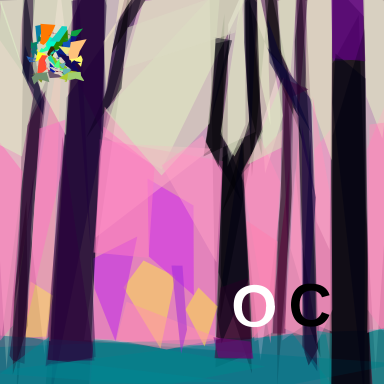

(0.6674642107811224, 0.736581791008385, 0.4853076934814453, 1.0)


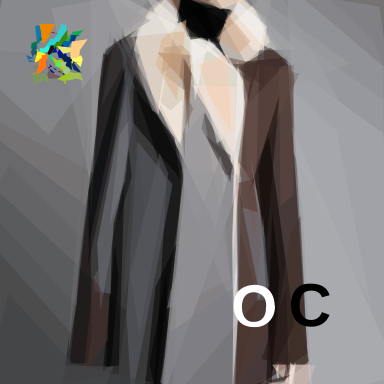

(0.6659875852923459, 0.7496989925604107, 0.46036853790283205, 1.0)


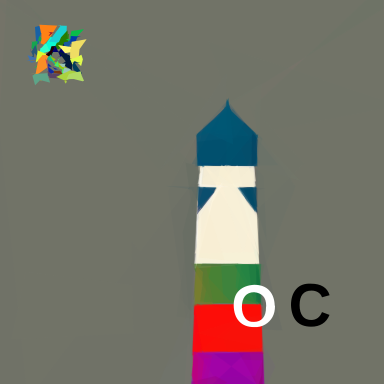

(0.6868473351428679, 0.7496263725758525, 0.5144968509674073, 1.0)


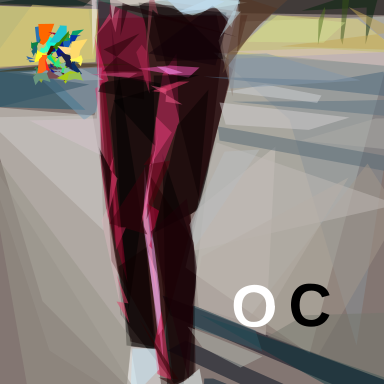

(0.7251274331172469, 0.81234315827548, 0.5072762966156006, 1.0)


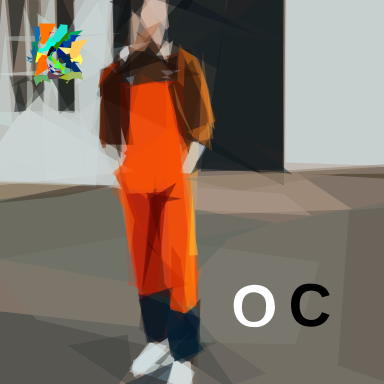

(0.6882230758886302, 0.74966910959857, 0.5182961463928223, 1.0)


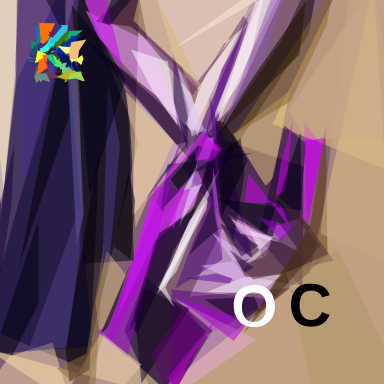

(0.6919479489100012, 0.7521964739510663, 0.5240492820739746, 1.0)


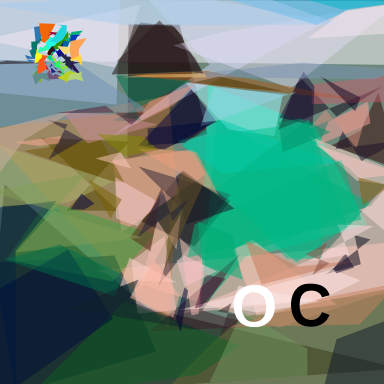

(0.7262303951680493, 0.8172877518346406, 0.5023534297943115, 1.0)


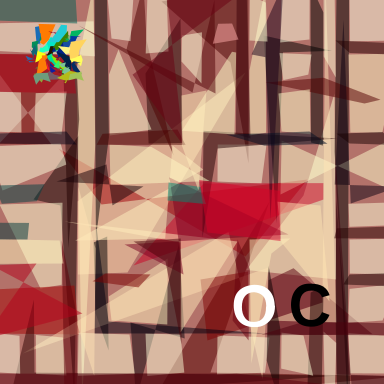

(0.6921592266162138, 0.7438702356992465, 0.5415682315826416, 1.0)


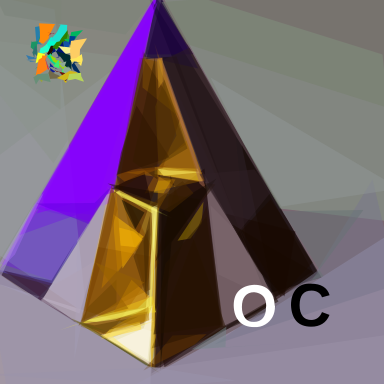

(0.5262630939087017, 0.5312728257487958, 0.5071346282958984, 1.0)


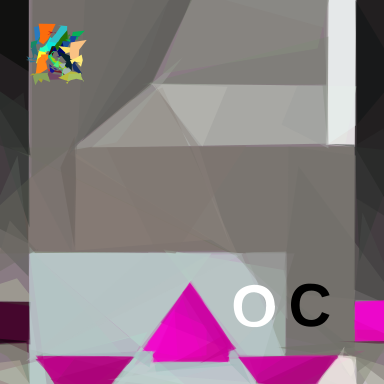

(0.7098858222495616, 0.7499322507904921, 0.5849420547485351, 1.0)


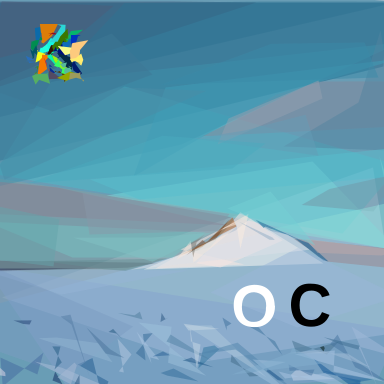

(0.6805609617322044, 0.750277464570907, 0.49615001678466797, 1.0)


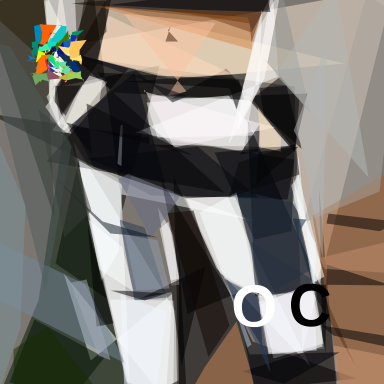

(0.7204565142575926, 0.7743967289563728, 0.5634650230407715, 1.0)


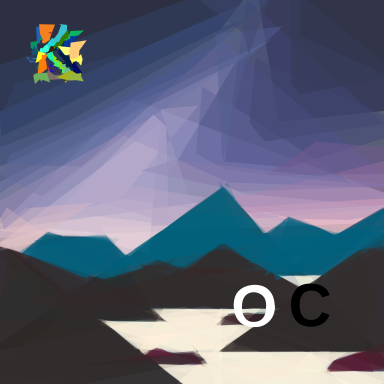

(0.6554771558987897, 0.7258785791287676, 0.4722622871398926, 1.0)


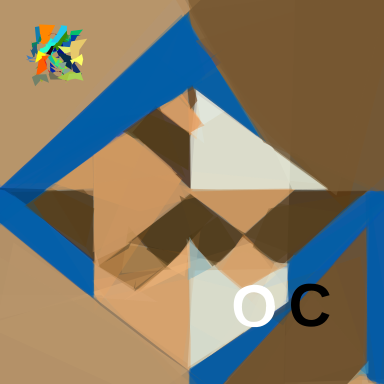

(0.5785977977244843, 0.6005311157086183, 0.5048437595367432, 1.0)


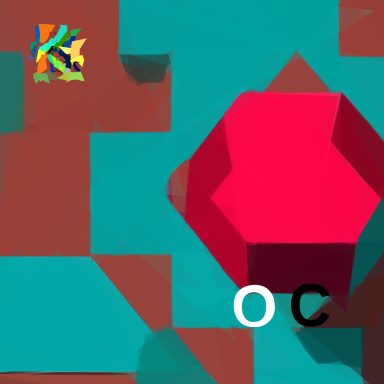

In [24]:
for svg, score in zip(submission["svg"], all_scores):
    img = svg_to_png(svg)
    print(score)
    display(img)

In [25]:
# torch.cuda.empty_cache()

# train_question_df["answer"] = [json.dumps(x) for x in train_question_df["answer"].values]
# train_question_df["choices"] = [json.dumps(x.tolist()) for x in train_question_df["choices"].values]
# train_question_df["question"] = [json.dumps(x) for x in train_question_df["question"].values]

# pred_df = pd.read_csv("./pred.csv").sort_values("id").reset_index(drop=True)

# res = score(
#     train_question_df,
#     pred_df,
#     "id"
# )

# print(res[0])
# print(np.mean([x[1] for x in res[1]]))
# print(np.mean([x[2] for x in res[1]]))
# print(np.mean([x[3] for x in res[1]]))